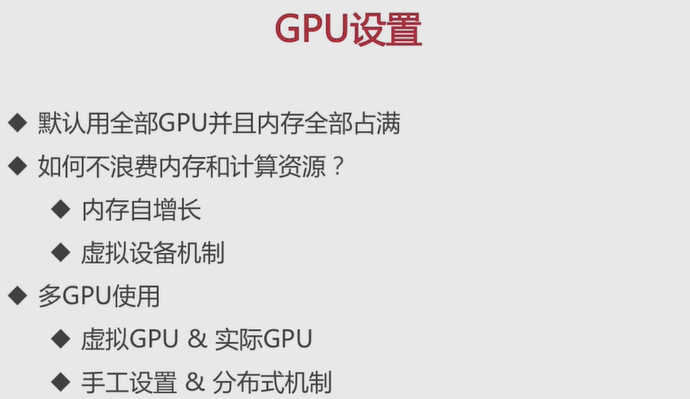

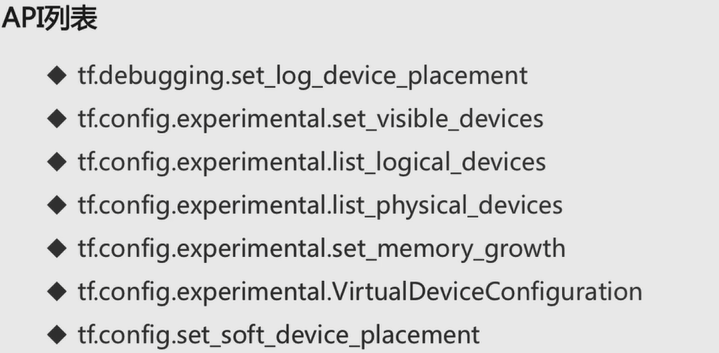

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import pandas as pd
import os, sys, time

import tensorflow as tf
from tensorflow import keras

%matplotlib inline

print(tf.__version__)
print(sys.version_info)

2.0.0
sys.version_info(major=3, minor=6, micro=8, releaselevel='final', serial=0)


### GPU config

In [ ]:
# 模型分布在不同GPU情况
tf.debugging.set_log_device_placement(True)

# 分配给计算单元合适的计算设备
tf.config.set_soft_device_placement(True)

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

# 设置可见GPU
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

# 内存自增长设置
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

logical_gpus = tf.config.experimental.list_logical_devices('GPU')
print(logical_gpus)

#### 逻辑划分GPU

In [ ]:
# 模型分布在不同GPU情况
# tf.debugging.set_log_device_placement(True)

# # 分配给计算单元合适的计算设备
# tf.config.set_soft_device_placement(True)

# gpus = tf.config.experimental.list_physical_devices('GPU')
# print(gpus)

# # 设置可见GPU
# tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
# # 设置虚拟GPU
# tf.config.experimental.set_virtual_device_configuration(
#     gpus[0], 
#     [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1000),
#      tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1000)]
# )

#### 使用不同设备

In [ ]:
# c = []
# for gpu in logical_gpus:
#     print(gpu)
#     with tf.device(gpu.name):
#         a = tf.constant([1. , 2.])
#         c.append(a)
        
# with tf.device('/CPU:0'):
#     b = tf.constant([2. , 3.])

### code

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[: 5000], x_train_all[5000: ]
y_valid, y_train = y_train_all[: 5000], y_train_all[5000: ]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [3]:
from sklearn.preprocessing import StandardScaler


scalar = StandardScaler()
x_train = scalar.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28, 1)
x_valid = scalar.fit_transform(
    x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28, 1)
x_test = scalar.fit_transform(
    x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28, 1)

In [4]:
def make_dataset(images, labels, epochs, batch_size, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if shuffle:
        dataset = dataset.shuffle(10000)
    dataset = dataset.repeat(epochs).batch(batch_size).prefetch(50)
    return dataset

batch_size = 128
epochs = 100
trainset = make_dataset(x_train, y_train, epochs, batch_size)
validset = make_dataset(x_valid, y_valid, epochs, batch_size)
testset = make_dataset(x_test, y_test, epochs, batch_size)

In [5]:
model = keras.models.Sequential()
with tf.device(logical_gpus[0].name):
    model.add(keras.layers.Conv2D(filters=32, kernel_size=3,
                                                        padding='same',
                                                        activation='relu',
                                                        input_shape=(28, 28, 1)))
with tf.device(logical_gpus[1].name):
    model.add(keras.layers.SeparableConv2D(filters=32, kernel_size=3,
                                                                    padding='same',
                                                                    activation='relu'))
    model.add(keras.layers.MaxPool2D(pool_size=(2, 2)))
with tf.device('/CPU:0')
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(10, activation='softmax'))

# y -> should be one-hot vector
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

# model.layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
separable_conv2d (SeparableC (None, 28, 28, 32)        1344      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                62730     
Total params: 64,394
Trainable params: 64,394
Non-trainable params: 0
_________________________________________________________________


In [7]:
logdir = '.\cnn-callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)

output_model_file = os.path.join(logdir, 'fashion_mnist_model.h5')

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file,
                                    save_best_only=True),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3)
]

history = model.fit(trainset, epochs=10, validation_data=validset, 
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    callbacks=callbacks)

Train for 429 steps, validate for 3907 steps
Epoch 1/10
429/429 [==============================] - 32s 75ms/step - loss: 1.3717 - accuracy: 0.5570 - val_loss: 0.6730 - val_accuracy: 0.7718
Epoch 2/10
429/429 [==============================] - 26s 61ms/step - loss: 0.6686 - accuracy: 0.7682 - val_loss: 0.5622 - val_accuracy: 0.8122
Epoch 3/10
429/429 [==============================] - 26s 61ms/step - loss: 0.5817 - accuracy: 0.7961 - val_loss: 0.5819 - val_accuracy: 0.8078
Epoch 4/10
429/429 [==============================] - 27s 62ms/step - loss: 0.5224 - accuracy: 0.8157 - val_loss: 0.4672 - val_accuracy: 0.8430
Epoch 5/10
429/429 [==============================] - 27s 62ms/step - loss: 0.4925 - accuracy: 0.8257 - val_loss: 0.5118 - val_accuracy: 0.8280
Epoch 6/10
429/429 [==============================] - 26s 62ms/step - loss: 0.4666 - accuracy: 0.8354 - val_loss: 0.4351 - val_accuracy: 0.8520
Epoch 7/10
429/429 [==============================] - 27s 62ms/step - loss: 0.4491 - accura

实时查看gpu运行情况： $ watch -n 0.1 -x nvidia-smi

In [ ]:
def plot_learning_curve(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curve(history)

### 分布式

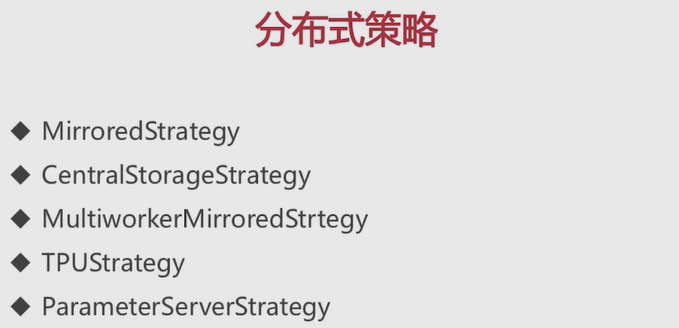

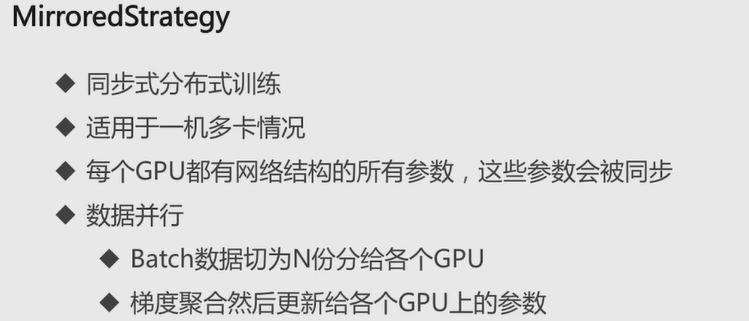

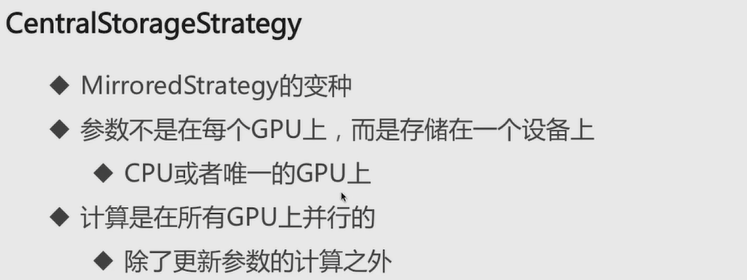
更新位置，看参数储存位置

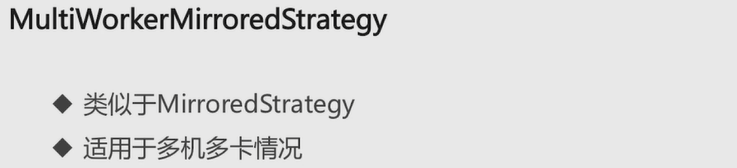

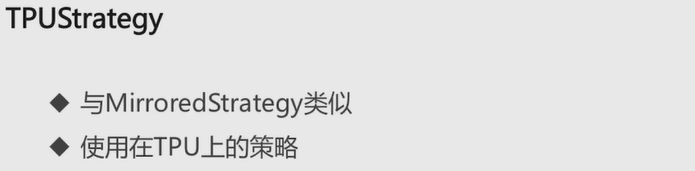

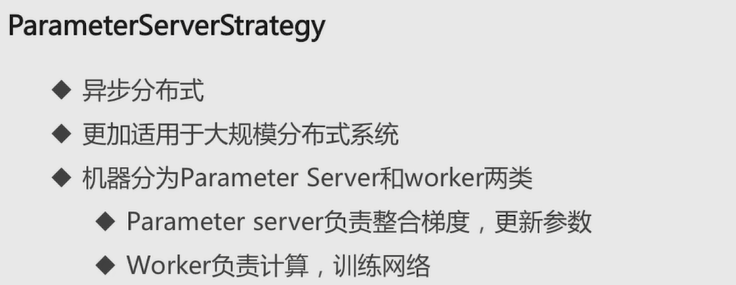
更好一些的分布式策略

#### ParameterServer

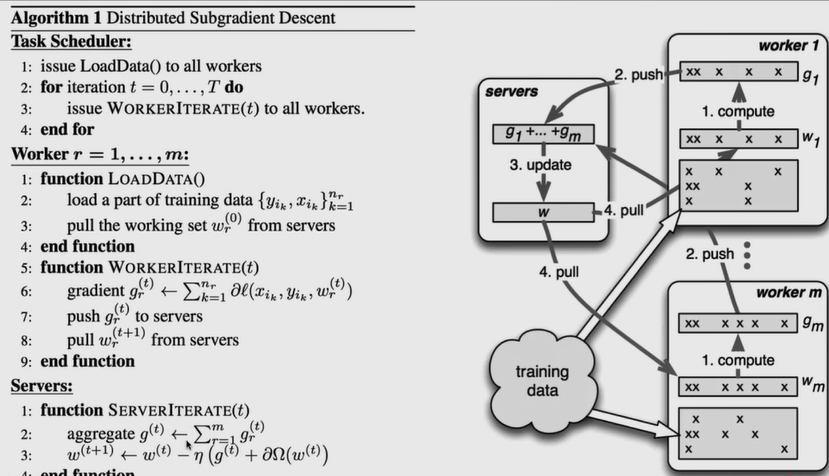

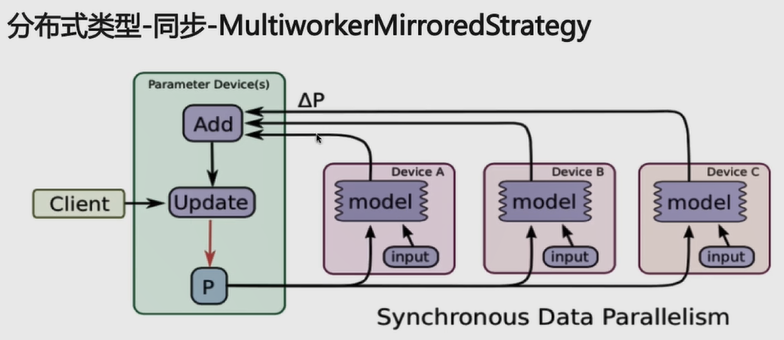

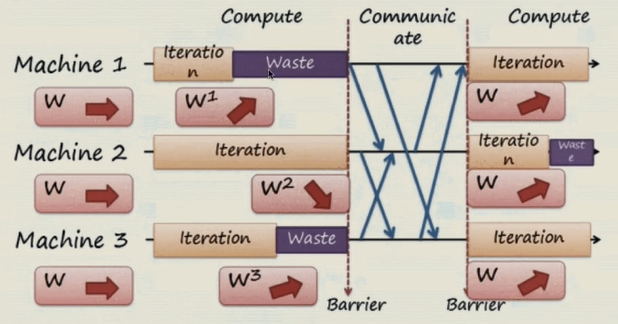

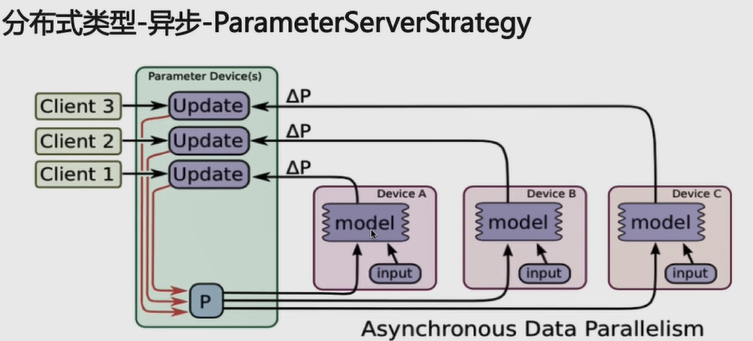

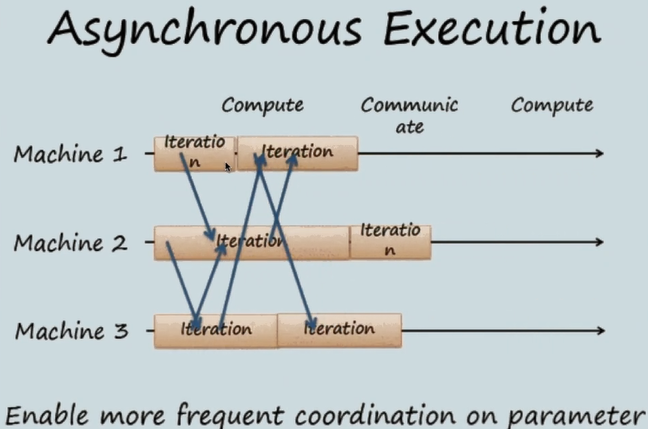

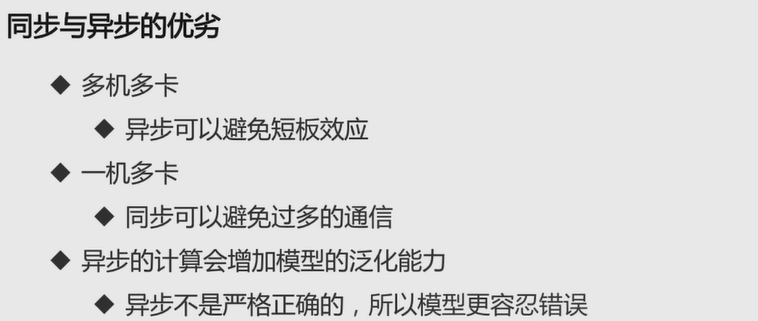

### MirroredStrategy

In [ ]:
# 模型分布在不同GPU情况
tf.debugging.set_log_device_placement(True)

# 分配给计算单元合适的计算设备
tf.config.set_soft_device_placement(True)

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

# 内存自增长设置
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

logical_gpus = tf.config.experimental.list_logical_devices('GPU')
print(logical_gpus)

In [ ]:
batch_size = len(gpus) * batch_size_single_gpu  # 数据并行

In [ ]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = keras.models.Sequential()
    with tf.device(logical_gpus[0].name):
        model.add(keras.layers.Conv2D(filters=32, kernel_size=3,
                                                            padding='same',
                                                            activation='relu',
                                                            input_shape=(28, 28, 1)))
    with tf.device(logical_gpus[1].name):
        model.add(keras.layers.SeparableConv2D(filters=32, kernel_size=3,
                                                                        padding='same',
                                                                        activation='relu'))
        model.add(keras.layers.MaxPool2D(pool_size=(2, 2)))
    with tf.device('/CPU:0')
        model.add(keras.layers.Flatten())
        model.add(keras.layers.Dense(10, activation='softmax'))

    # y -> should be one-hot vector
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='sgd',
                  metrics=['accuracy'])

    # model.layers
    model.summary()

#### estimator

In [ ]:
strategy = tf.distribute.MirroredStrategy()
config = tf.estimator.RunConfig(train_distribute=strategy)
# 数据没有并行，设置较大的batch size，速度才能更快
estimator = keras.estimator.model_to_estimator(model, config=config)

#### 自定义

In [ ]:
# 数据集改造
with strategy.scope():
    batch_size_per_device = 256
    batch_size = batch_size_per_device * len(logical_gpus)
    trainset = make_dataset(x_train, y_train, epochs, batch_size)
    validset = make_dataset(x_valid, y_valid, epochs, batch_size)
    testset = make_dataset(x_test, y_test, epochs, batch_size)
    
    # 每个gpu单独对应一个dataset，提供数据，提升速度
    trainset_dist = strategy.experimental_distribute_dataset(trainset)
    validset_dist = strategy.experimental_distribute_dataset(validset)
    testset_dist = strategy.experimental_distribute_dataset(testset)

In [ ]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    loss_fun = tf.losses.SparseCategoricalCrossentropy(
        reduction=keras.losses.Reduction.NONE)
    
    def compute_loss(labels, prediction):
        per_device_loss = loss_fun(labels, prediction)
        return tf.nn.compute_average_loss(per_device_loss,
                                                                 global_batch_size=batch_size)
    
    test_loss = keras.metrics.Mean(name='test_loss')

    train_acc = keras.metrics.SparseCategoricalAccuracy(name='train_acc')
    test_acc = keras.metrics.SparseCategoricalAccuracy(name='test_acc')

    optimizer = keras.optimizers.SGD(lr=0.01)

    def train_step(inputs):
        images, labels = inputs
        with tf.GradientTape as tape:
            prediction = model(images, training=True)
            loss = compute_loss(labels, prediction)
        gradients = tape.gradients(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        train_acc.update_state(labels, prediction)
        return loss
    
    @tf.function
    def dist_train_step(inputs):
        per_device_loss = strategy.experimental_run_v2(
            train_step, args=(inputs, ))
        return strategy.reduce(tf.distribute.ReduceOp.SUM,
                                             per_device_loss,
                                             axis=None)
    
    def test_step(inputs):
        images, labels = inputs
        prediction = model(images)
        t_loss = loss_fun(labels, prediction)
        test_loss.update_state(t_loss)
        test_acc.update_state(labels, prediction)
        
    @tf.function
    def dist_test_step(inputs):
        strategy.experimental_run_v2(
            test_step, args=(inputs, ))

    epochs = 10
    for epoch in range(epochs):
        total_loss = 0.0
        num_batches = 0
        for x in trainset:
            start_time = time.time()
            total_loss += dist_train_step(x)
            run_time = time.time() - start_time
            num_batches += 1
        train_loss = total_loss / num_batches
        for x in valid_dataset:
            dist_test_step(x)

        test_loss.reset_states()
        train_acc.reset_states()
        test_acc.reset_states()